# The cross-section of stock returns

Now that we know the basics of portfolio allocation, we can take a closer look at what determines individual asset prices.

Let's start with stocks. There are two main types of data for this: time series and cross-sectional. A time series reflects how a single stock price evolves over time. A cross-section shows how prices of different assets compare with each other, in function of another variable.

In this chapter our focus shall be the cross-section of stock returns.

## Capital Asset Pricing Model

It is common to look at the *excess* returns, that is, returns minus the risk-free rate. This is because the risk-free rate is assumed to be the return earned on an investment free of risk. In order to earn more than the risk-free rate, investors must take up on risk.

Stocks are risky assets. Cross-sectional analysis of stock returns seek to quantify how much each source of risk contributes to excess returns.

One of the main sources of risk for stocks is market risk. If a stock has high market risk, that means the stock will move up or down more intensely as the market as a whole moves up or down.

Market risk is the main foundation of the famous Capital Asset Pricing Model, or CAPM.

CAPM consists of a linear regression of excess returns of each asset (stocks) on excess market returns. The excess return $R_i$ for stock $i$ over the risk-free rate $R_f$ is estimated as

$(R_i - R_f)(t) = \alpha_i + \beta_i (R_m - R_f)(t) + \varepsilon_i(t)$,

where $R_m$ is the market return. It is common to refer to the regression intercept and coefficient as "alpha" and "beta". The intercept, $\alpha$, corresponds to the portion of excess returns that is not explained by excess market returns. The coefficient, $\beta$, measures the sensitivity of the excess returns of a certain asset to the excess market returns.

We can try to estimate a CAPM with market data. Let's use SPY as a proxy for the American market.

<Axes: xlabel='Date'>

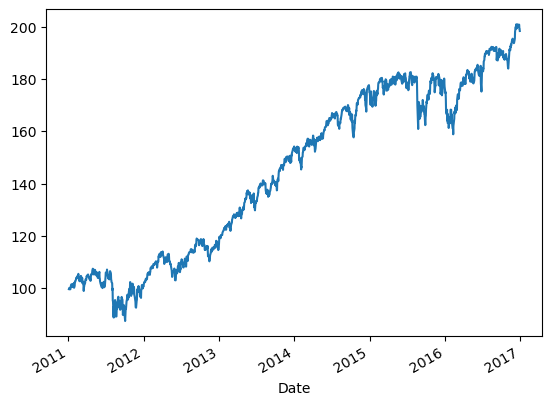

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

start_date = "2011-01-01"
end_date = "2017-01-01"

spy = yf.Ticker("SPY").history(start = start_date, end = end_date)

spy['Close'].plot()

The graph above is a time series. We need to obtain the returns, which are also a time series:

<Axes: xlabel='Date'>

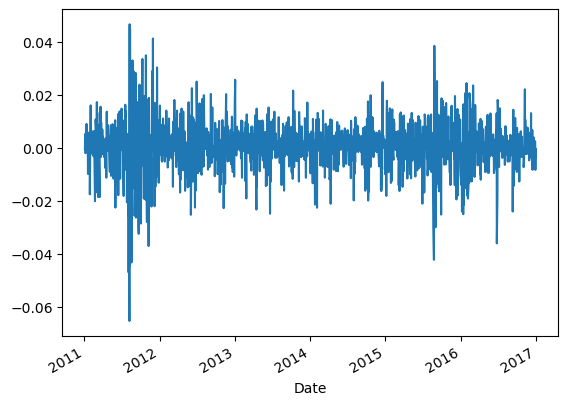

In [2]:
spy_ret = spy['Close'].pct_change().dropna()
spy_ret.plot()

Now we need data for any stock. Let's try CSCO

<Axes: xlabel='Date'>

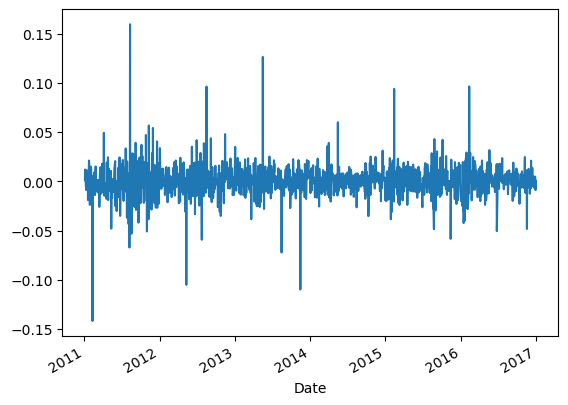

In [3]:
csco = yf.Ticker("CSCO").history(start = start_date, end = end_date)
csco_ret = csco['Close'].pct_change().dropna()
csco_ret.plot()

We shall use the 3-month Treasury bill rates to obtain the risk-free rate of return. It is possible to get those from Yahoo finance, via the IRX index. It already is an "annualized return", however, it is quoted as a percentage, so we divide by 100.

<Axes: xlabel='Date'>

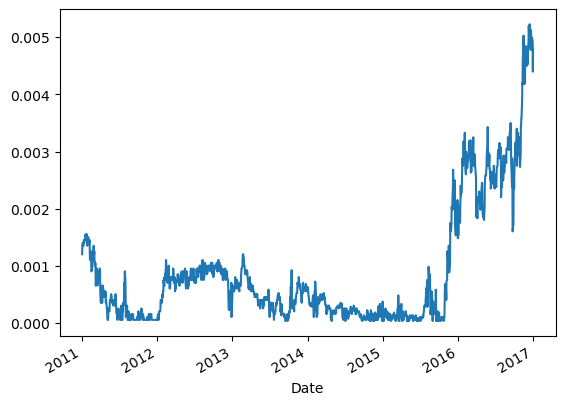

In [4]:
risk_free = yf.Ticker("^IRX").history(start = start_date, end = end_date)['Close']/100
risk_free.plot()

We then obtain our excess returns and treat the time series observations of SPY and CSCO as a cross-section:

In [5]:
spy_excess = (spy_ret - risk_free[1:]).dropna()
csco_excess = (csco_ret - risk_free[1:]).dropna()

Text(0, 0.5, 'CSCO')

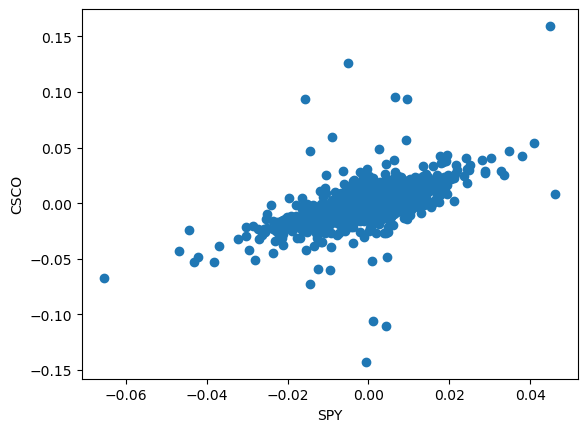

In [6]:
plt.scatter(spy_excess,csco_excess)
plt.xlabel('SPY')
plt.ylabel('CSCO')

Now we can estimate our linear regression. We shall use the library statsmodels.

In [7]:
import statsmodels.api as sm

model = sm.OLS(csco_excess, sm.add_constant(spy_excess)) # add_constant so that our model has an intercept
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     914.9
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          2.03e-157
Time:                        09:20:36   Log-Likelihood:                 4456.4
No. Observations:                1507   AIC:                            -8909.
Df Residuals:                    1505   BIC:                            -8898.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.062e-06      0.000     -0.022      0.9

In [8]:
print("Annualized alpha: " + str((results.params["const"] * 252 * 100).round(2)) + "%")

Annualized alpha: -0.18%


We can use seaborn, another graphical library, to get a scatterplot with the regression line:

<Axes: xlabel='Close', ylabel='Close'>

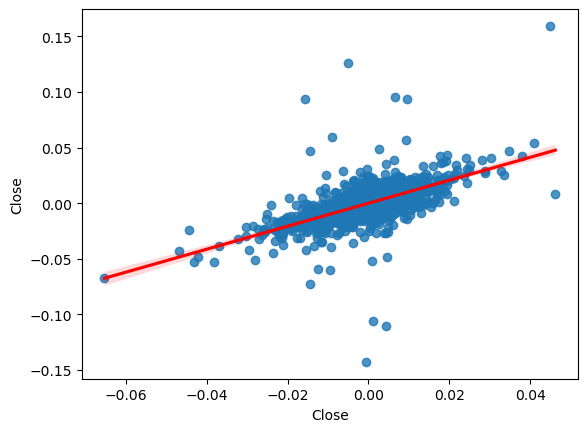

In [9]:
import seaborn as sns

sns.regplot(x=spy_excess, y=csco_excess, line_kws = {'color' : 'r'})

The red line above is our CAPM model.

Now let's try with another stock, GOOG:

In [10]:
goog = yf.Ticker("GOOG").history(start = start_date, end = end_date)
ret = goog['Close'].pct_change().dropna()
excess = (ret - risk_free[1:]).dropna()
model = sm.OLS(excess, sm.add_constant(spy_excess)) # add_constant so that our model has an intercept
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     825.7
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          4.03e-145
Time:                        09:20:38   Log-Likelihood:                 4474.9
No. Observations:                1507   AIC:                            -8946.
Df Residuals:                    1505   BIC:                            -8935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.714      0.4

In [11]:
print("Annualized alpha: " + str((results.params["const"] * 252 * 100).round(2)) + "%")

Annualized alpha: 5.76%


<Axes: xlabel='Close', ylabel='Close'>

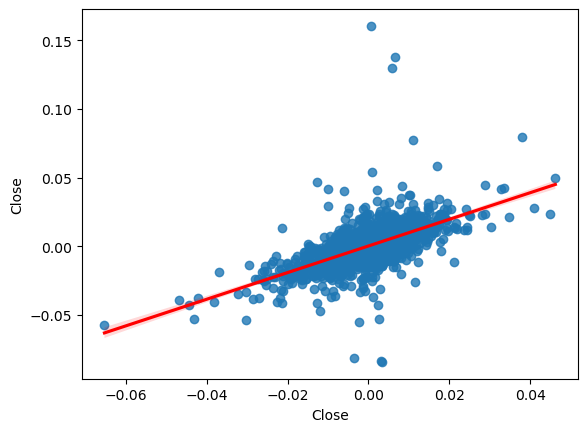

In [12]:
sns.regplot(x=spy_excess, y=excess, line_kws = {'color' : 'r'})

## Market portfolio and the CML

The CAPM may seem like a simple model, but has strong implications for theory. It gives us a better understanding of the risk-return tradeoff. 

With the introduction of a risk-free asset, agents now face the choice of how much to allocate between the riskless rate and risky assets. This choice ultimately depends on each investors' risk preferences. But how to choose between risky assets?

Market capitalizations of each asset implicitly contain how much the market values the asset in question. If the market perceived a certain asset as cheap, it would purchase more of it, increasing its capitalization. Conversely, if the asset were perceived to be overvalued, the market would sell more of it, decreasing market cap. So the current market capitalizations reflect market equilibrium. This idea was also used in the derivation of the Black-Litterman prior for the mean returns, $\Pi$, and deriving it via CAPM would yield similar results. 

The implication of the CAPM is that all investors in the market would come to a single allocation when it comes to choosing between risky assets. This allocation is called the market portfolio. In the CAPM, all investors would divide their wealth between the risk-free asset and the market portfolio. 

Another way to look at it is thinking about the fact that individual assets, e.g., stocks, each have idiosyncratic risk. If, by diversification, agents could get rid of the idiosyncratic risk, they would all eventually reach the market portfolio allocation in the CAPM world.

The market portfolio is also called the tangency portfolio. This is due to the fact that, if we draw the risk-return tradeoff as a linear relationship on the risk-return plane, where the risk-free rate is the intercept of the return axis, this line will intersect the Markowitz efficient frontier at one point, the market portfolio. The line is known as the Capital Market Line, or CML.

[                       0%%                      ]

[*******************   40%%                      ]  2 of 5 completed

[**********************60%%***                   ]  3 of 5 completed

[**********************80%%************          ]  4 of 5 completed

[*********************100%%**********************]  5 of 5 completed

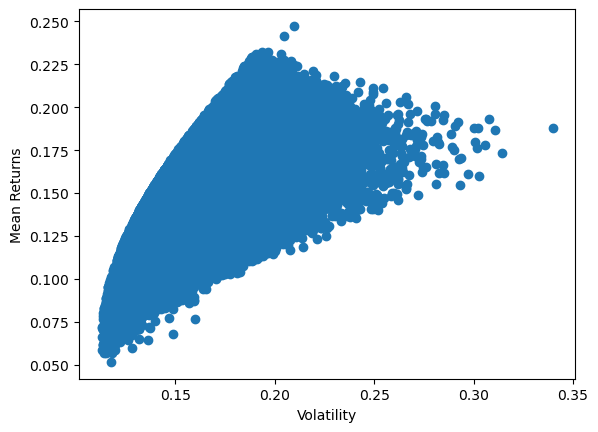

In [13]:
data = yf.download("GOOG TSLA BAC KO PFE", start="2015-01-01", end="2018-01-01")["Close"]

market_mean_returns = (data.pct_change().dropna().mean() * 252).values
market_cov = (data.pct_change().dropna().cov() * 252).values

port_returns = []
port_vol = []

for i in range(100000):
    weights = np.random.random(5)
    weights /= np.sum(weights)
    i_returns = weights @ market_mean_returns
    i_vol = np.sqrt(weights.T @ (market_cov @ weights))    
    port_returns.append(i_returns)
    port_vol.append(i_vol)

plt.xlabel("Volatility")
plt.ylabel("Mean Returns")
plt.scatter(port_vol,port_returns)

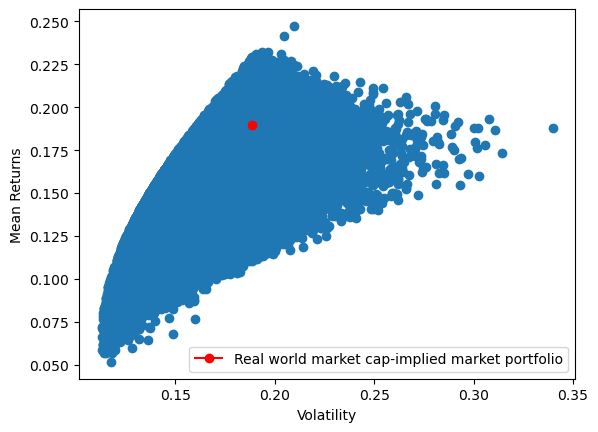

In [14]:
tickers = ["GOOG", "TSLA", "BAC", "KO", "PFE"]
market_caps = np.empty(len(tickers))
for i in range(0,len(tickers)):
    market_caps[i] = yf.Ticker(tickers[i]).info["marketCap"]

w_mkt = market_caps/np.sum(market_caps)

ret_mkt = w_mkt @ market_mean_returns
vol_mkt = np.sqrt(w_mkt.T @ (market_cov @ w_mkt))
plt.scatter(port_vol,port_returns)
plt.plot(vol_mkt,ret_mkt, marker="o", color="r", label="Real world market cap-implied market portfolio")
plt.xlabel("Volatility")
plt.ylabel("Mean Returns")
plt.legend()
plt.show()

The fact that the market portfolio implied from real world market caps does not lie on the efficient frontier is a clear sign of the differences between the real world and the CAPM world.

[*********************100%%**********************]  1 of 1 completed

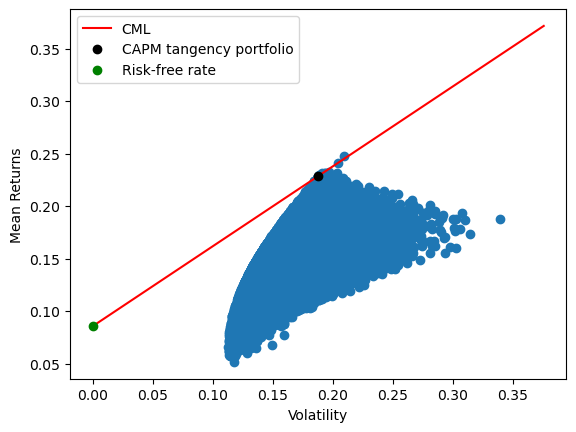

In [15]:
import scipy.optimize as opt

risk_free = yf.download("^IRX", start="2015-01-01", end="2018-01-01")["Close"]
mean_risk_free = risk_free.pct_change().dropna().mean()

tang_index = [a/b for a,b in zip(port_returns,port_vol)].index(np.max([a/b for a,b in zip(port_returns,port_vol)]))

plt.scatter(port_vol,port_returns)
slope = port_vol[tang_index]/(port_returns[tang_index]-mean_risk_free)
plt.plot([0.,port_vol[tang_index]*2],[mean_risk_free,(port_returns[tang_index]*2)-mean_risk_free], color='r', label='CML')
plt.plot(port_vol[tang_index],port_returns[tang_index], "ko", label="CAPM tangency portfolio")
plt.plot(0,mean_risk_free, "go", label="Risk-free rate")
plt.xlabel("Volatility")
plt.ylabel("Mean Returns")
plt.legend()
plt.show()

What are the risk properties of the market portfolio? That is, how does the market price risk? The market price of risk can be imagined as the extra compensation agents are willing to take for more exposure to risk. Its formula is

$MPR_i = \frac{\operatorname{E}[R_i] - R_f}{\sigma^2_i}$,

where $\operatorname{E}[R_i]$ is the expected return for asset $i$ and $\sigma^2_i$ is the variance of returns, which stands for risk. The numerator is the excess return on the market portfolio and receives the name of risk premium. 

The market price of risk embodies the risk preferences of the market as a whole. Whenever an indivitual investor's risk preferences diverges from the market, that investor will borrow or lend at the risk-free rate, with borrowers becoming more leveraged at the market portfolio and lenders earning more at the risk-free rate. The net borrowing of the economy shall equal zero.

The MPR is also the slope of the CML we obtained in the previous step, and is related to the Sharpe ratio. The formula for the Sharpe ratio is very similar to the market price of risk, and the only difference is that the denominator of the Sharpe ratio is the standard deviation of returns, and not the variance.

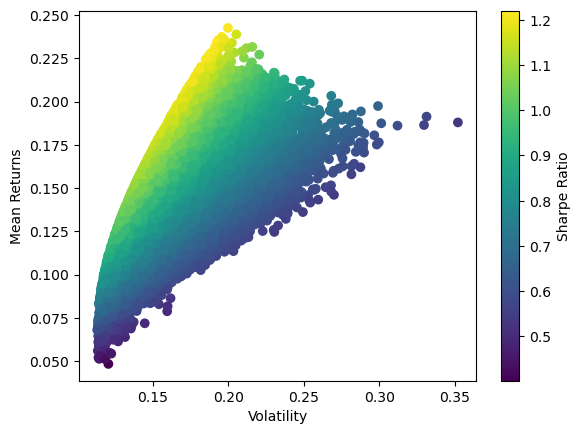

In [16]:
port_returns = []
port_vol = []
sharpe_ratio = []

for i in range(100000):
    weights = np.random.random(5)
    weights /= np.sum(weights)
    i_returns = weights @ market_mean_returns
    i_vol = np.sqrt(weights.T @ (market_cov @ weights))
    i_sr = i_returns/i_vol
    port_returns.append(i_returns)
    port_vol.append(i_vol)
    sharpe_ratio.append(i_sr)

plt.scatter(port_vol,port_returns, c=sharpe_ratio)
plt.xlabel("Volatility")
plt.ylabel("Mean Returns")
plt.colorbar(label="Sharpe Ratio")

## Fama-MacBeth regressions

The CAPM theoretical implications may not perfecly show themselves in practice, but they help us understand how financial markets work. To what extent does the empirical evidence support the CAPM conclusions?

First of all, the true CAPM would involve knowing the true market portfolio, which would require that we took into account every single risky asset in the economy. This is impossible, in practice. Then how can we come up with an empirical test for the CAPM?

We can rely on another implication of the CAPM, that the returns for different assets should be "on average" proportional to their betas. Then, with a large enough set of assets we can obtain a large enough set of betas, and from there perform tests.

Fama and MacBeth (1973) designed a two-step procedure. First, we take the time series returns of each asset, turning it into a cross section, and run regressions of the asset returns versus market returns along time for each asset, so we can get an estimated beta for each asset. The second step consists of running regressions of the returns of different assets at each time period versus their betas, so we can get an estimated market price of risk at each time.

In the first step we run a regression for each asset versus the market returns. In the second one, we run a regression for each period of time with the estimated betas from the first step as our independent variable.

A regression for the first step for a given asset $i$ would look like

$R_{i,t} = a_i + \beta_i M_{t} + \varepsilon_{i,t}$,

where $M_t$ is the market return at time $t$. We would obtain a $\hat{\beta}_i$ for each asset $i$.

The second step regressions, for a given time period $t$, are of the form

$R_{i,t} = \lambda_t \hat{\beta}_i + \alpha_{i,t}$.

In this last equation the errors $\alpha_{i,t}$ have a specific interpretation: they are the portion of each asset unexplained by the factor beta. This is also known as Jensen's alpha. The residuals $\hat{\alpha}_{i,t}$ are the pricing errors according to the model. 

The estimate for the market price of risk over the time period for the whole sample is the average of all estimated market prices of risk along time. The estimate for the Jensen's alpha of each asset $i$ is also the average of the residuals $\hat{\alpha}_{i,t}$ along time $t=1,\ldots,T$. It is worth noticing that, in the original Fama-MacBeth method, the estimates for $\lambda$ are not biased, but their standard errors are.

Since the estimate for $\lambda$ is the average of all estimated $\lambda_t$'s over time, We can run the regression over average returns along time $\overline{R}_i$ for each asset. We can also include a constant in the second step regression

$\overline{R}_i = \gamma + \lambda \hat{\beta}_i + u_i$.

If the CAPM is valid, we can match the equation above to the theoretical CAPM equation, and therefore $\gamma$ has to equal the risk-free rate and $\lambda$ should match the excess return on risky assets. The Fama-MacBeth empirical test for the CAPM consists of estimating the augmented regression

$\overline{R}_i = \gamma + \lambda \hat{\beta}_i + \delta_1 \hat{\beta}_i^2 + \delta_2 SD_i + u_i$,

where $SD_i$ are the standard deviations for the residuals of each asset in the first step regressions. As, according to the CAPM, the relationship between asset returns and betas is linear, and nothing other than the market risk should explain asset returns, then, if the CAPM is valid, $\delta_1$ and $\delta_2$ should both equal zero.

Below we present an example of Fama-MacBeth regressions.

In [17]:
tickers = pd.read_csv("https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv")["Symbol"].tolist()
tickers[401] = "RVTY"
tickers = list(map(lambda x: str.replace(x, ".", "-"), tickers))

fmb_betas = []
spy = yf.Ticker("SPY").history(start = "2021-01-01", end = "2023-12-30")
spy_ret = spy['Close'].pct_change().dropna()

returns_df = pd.DataFrame()
for i in tickers:
    price = yf.Ticker(i).history(start = "2021-01-01", end = "2023-12-30")
    ret = price['Close'].pct_change().dropna()
    returns_df = pd.concat((returns_df, ret.rename(i)), axis=1)
returns_df.columns = tickers
returns_df.dropna(axis=1, inplace=True)

# first step
residuals_sd = []

for i in returns_df.columns:
    model = sm.OLS(returns_df[i], sm.add_constant(spy_ret))
    results = model.fit()
    fmb_betas.append(results.params["Close"])
    residuals_sd.append(np.std(results.resid))

# second step
lamb_list = []
jensens_alpha_df = pd.DataFrame()

for i in range(len(returns_df)):
    model = sm.OLS(returns_df.iloc[i], fmb_betas)
    results = model.fit()
    lamb_list.append(results.params["x1"])
    jensens_alpha_df = pd.concat((jensens_alpha_df,results.resid),axis=0)

#test
augmented_df = pd.DataFrame()
augmented_df['beta'] = np.array(fmb_betas)
augmented_df['sq_beta'] = np.array(fmb_betas)**2
augmented_df['sd'] = residuals_sd
model = sm.OLS(returns_df.mean(), sm.add_constant(augmented_df).values)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     3.669
Date:                Thu, 11 Jan 2024   Prob (F-statistic):             0.0123
Time:                        09:24:39   Log-Likelihood:                 3048.0
No. Observations:                 499   AIC:                            -6088.
Df Residuals:                     495   BIC:                            -6071.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.723      0.4

In our sample, the results show that the idiosyncratic risk (i.e. the first step residuals) for each asset does not explain mean returns, as $\delta_1$ (x2) is not statistically significant, but $\delta_2$ (x3) is at the 10% level, meaning possible omitted factors in explaining asset returns.

## Multifactor models

Some empirical tests of the CAPM over the last decades reject it in favor of multifactor models. As the name implies, multifactor models rely on more than one factor in order to explain asset returns. 

The Fama-French 3 factor model is a current benchmark for the cross-section of stock returns. Besides the market factor, it also includes the "small minus big" and "high minus low", or SMB and HML factors. These factors capture the systematic risk for companies with small (versus big) market caps and high (versus low) book-to-market ratios.

Carhart (1997) suggests an additional factor, momentum, and presents a 4 factor model. 

Here we estimate Carhart's 4 factor model for the Brazilian market, with the momentum factor.

In [18]:
factors = pd.read_csv("http://nefin.com.br/resources/risk_factors/nefin_factors.csv").drop("Unnamed: 0", axis=1)
factors['date'] = pd.to_datetime(factors["date"])
factors.set_index("date", inplace=True)
MKT = factors["mkt-rf"]
SMB = factors['smb']
HML = factors['hml']
MOM = factors['mom']
factors['2012-01-01':'2018-01-01']

,mkt,rf,mkt-rf,smb,hml,mom,illiq
date,,,,,,,
2012-01-02,0.008443,0.000403,0.008041,0.010984,0.001223,-0.010802,0.004252
2012-01-03,0.018749,0.000402,0.018347,-0.005955,0.035185,-0.014981,0.011887
2012-01-04,-0.000414,0.000401,-0.000815,0.001948,0.019470,-0.003188,-0.001168
2012-01-05,-0.010354,0.000400,-0.010754,-0.001767,-0.003120,0.002764,0.004441
2012-01-06,-0.000838,0.000399,-0.001237,0.004133,-0.000962,-0.006387,-0.006364
...,...,...,...,...,...,...,...
2017-12-21,0.020247,0.000264,0.019982,0.002543,0.007074,-0.001702,0.002215
2017-12-22,0.000024,0.000264,-0.000241,0.009761,-0.003633,-0.011030,0.008627
2017-12-26,0.007100,0.000264,0.006836,-0.001920,-0.000744,0.001960,-0.000204


In [19]:
# four factor model

start_date = "2012-01-01"
end_date = "2018-01-01"
itsa = yf.Ticker("ITSA3.SA").history(start = start_date, end = end_date)
ret = itsa['Close'].pct_change().dropna()
ret.index = ret.index.tz_localize(None)
df = factors.join(ret).dropna()
df['excess'] = (df['Close'] - df["rf"])

model = sm.OLS(df['excess'], sm.add_constant(df.iloc[:,2:6])) # add_constant so that our model has an intercept
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     164.0
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          3.20e-116
Time:                        09:24:41   Log-Likelihood:                 3826.8
No. Observations:                1481   AIC:                            -7644.
Df Residuals:                    1476   BIC:                            -7617.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.273      0.7

As ITSA3 has both a big market cap and high market value (low book-to-market ratio), it makes sense that SMB and HML are not statistically significant in our model, and therefore do not help in explaining ITSA3 returns. The same goes for alpha, i.e., our model intercept and the momentum factor. However, the market excess returns ($R_m - R_f$) factor is statistically significant.

## Arbitrage Pricing Theory

We can also derive linear models for the cross section of stock returns in additional ways, such as the Arbitrage Pricing Theory (APT). 

An opportunity of earning more than the risk-free rate without taking on additional risk is known as arbitrage. APT is based on the premise of no-arbitrage, that is, whenever an arbitrage opportunity appears on the market, agents will take advantage of it, pricing it out and driving market back to equilibrium.

APT seeks to explain asset returns in function of explanatory variables known as factors. Factors can be the same ones as mentioned in the CAPM or Fama-French models, but also macroeconomic variables, for example. 

The main empirical challenge of APT is choosing the right amount of factors along with the variables to be employed as factors. This can be seen as a variable selection problem, or dimensionality reduction in machine learning terminology. 

If we take the market factor to be our only factor, the APT will reach similar conclusions as the CAPM. The APT, however, has "weaker" premises behind it. The CAPM requires all market agents to be "mean-variance optimizers", while the APT only requires that a subset of market agents be pricing out arbitrage opportunities.

Here we try to estimate an APT model for ITSA3 with inflation, industrial capacity and exchange rate as factors.

In [20]:
infl = pd.read_csv("http://api.bcb.gov.br/dados/serie/bcdata.sgs.16122/dados?formato=csv", sep=";",decimal=',').set_index("data")
infl.index = pd.to_datetime(infl.index, dayfirst=1)
ind_cap = pd.read_csv("http://api.bcb.gov.br/dados/serie/bcdata.sgs.28561/dados?formato=csv", sep=";",decimal=',').set_index("data")
ind_cap.index = pd.to_datetime(ind_cap.index, dayfirst=1)
exch_rate = pd.read_csv("http://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=csv", sep=";",decimal=',').set_index("data")
exch_rate.index = pd.to_datetime(exch_rate.index, dayfirst=1)

In [21]:
factors = pd.concat([infl,ind_cap,exch_rate.asfreq("MS", method="bfill")], axis=1)['2005-01-01':'2020-01-01']
factors.columns = ["Inflation","Industrial capacity","Exchange rate"]
factors

,Inflation,Industrial capacity,Exchange rate
data,,,
2005-01-01,0.65,83.6,2.6674
2005-02-01,0.65,84.0,2.6122
2005-03-01,0.76,82.9,2.6003
2005-04-01,0.79,82.7,2.6542
2005-05-01,0.56,81.3,2.5138
...,...,...,...
2019-09-01,0.08,75.5,4.1575
2019-10-01,0.21,75.7,4.1734
2019-11-01,0.44,75.4,3.9780


In [22]:
itsa = yf.Ticker("ITSA3.SA").history(start = '2004-12-10', end = '2020-01-01')
ret = itsa['Close'].asfreq("MS", method="ffill").pct_change().dropna()
ret.index = ret.index.tz_localize(None)

In [23]:
df = factors.join(ret.rename("returns")).dropna()

In [24]:
model = sm.OLS(df['returns'], sm.add_constant(df.iloc[:,:3]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.787
Date:                Thu, 11 Jan 2024   Prob (F-statistic):              0.151
Time:                        09:24:46   Log-Likelihood:                 197.25
No. Observations:                 179   AIC:                            -386.5
Df Residuals:                     175   BIC:                            -373.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.5132    

## Additional references for this section

Bodie, Z., Kane, A., Marcus, A. J. (2018). Investments. Chapter 9 contains a conceptual derivation of the CAPM and its relation to the efficient frontier, while Chapter 10 introduces APT and multifactor models. 

MacKinlay, A. C., Lo, A. W., Campbell, J. Y. (2012). The Econometrics of Financial Markets. Chapter 5 is focused around the empirical estimation of the CAPM and details the Fama-MacBeth procedure, while Chapter 6 is about APT and multifactor models.